## Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузить данные и выполните их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
print(data.index.is_monotonic)
print(data.info())
data

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


***Изменяем тип данных на DataFrame и вместо индексов делаем даты. После проверяем расположены ли даты по порядку.***

In [3]:
data = data.resample('1H').sum()  # интервал 1 час с суммой значений 
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


***Задаем интервал 1 час с суммой значений***

# 2. Анализ

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,169.18
2018-08-31 20:00:00,154,169.86
2018-08-31 21:00:00,159,169.66


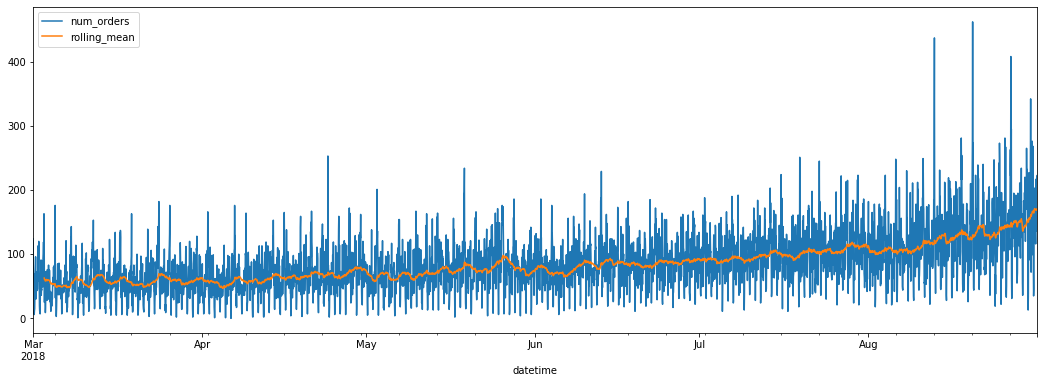

In [4]:
data['rolling_mean'] = data.rolling(50).mean() # Скользящее среднее с окном 50
data.plot(figsize=(18, 6))
data

***Скользящее среднее (Проверяем тенденцию)***

In [5]:
data = data.drop(['rolling_mean'], axis=1)

***Удаляем не нужный столбец***

Text(0.5, 1.0, 'Сезонность')

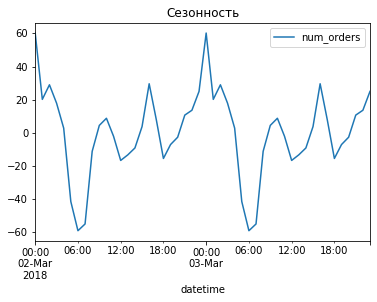

In [6]:
decomposed = seasonal_decompose(data)

decomposed.seasonal['2018-03-02':'2018-03-03'].plot()
plt.title('Сезонность')

***Количестов заказов падает ночью (Люди спят)***

Text(0.5, 1.0, 'Тренд')

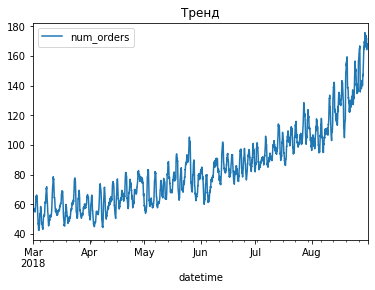

In [7]:
decomposed.trend.plot()
plt.title('Тренд')

***По тренду видно что количество заказов растет (Комания развивается и захватывает рынок)***

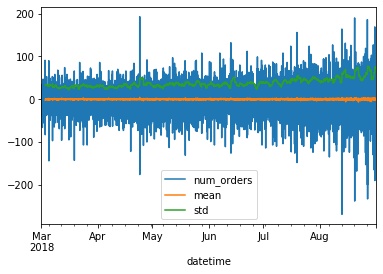

In [8]:
data_1 = data - data.shift() # смещение значения что-бы ряд стал стацонарным 
data_1['mean'] = data_1['num_orders'].rolling(50).mean()
data_1['std'] = data_1['num_orders'].rolling(50).std()
data_1.plot()

***смещение значений нужно что-бы ряд стал стацонарным***

# 3. Обучение

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    # четыре новых календарных признака: год, месяц, день и день недели
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # отстающие значения. max_lag, который задаст максимальный размер отставания. 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 150, 150)
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,162.0,105.0,123.0,123.0,158.0,182.0,150.0,130.0,63.0,154.173333
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,155.0,162.0,105.0,123.0,123.0,158.0,182.0,150.0,130.0,154.660000
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,174.0,155.0,162.0,105.0,123.0,123.0,158.0,182.0,150.0,154.820000


***Задаем четыре новых календарных признака, макисмальный размер отставания и скользящее стреднее с разными размерами. Их величина влияет на качетсво модели.***

In [10]:
train, valid, test = np.split(data.sample(frac=1, random_state=12345),
                                 [int(.6*len(data)), int(.8*len(data))])

train = train.dropna()
valid = valid.dropna()
test = test.dropna()
# переменные для признаков и целевого признака
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders'] 

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print(train.shape)
print(valid.shape)
print(test.shape)


(2563, 156)
(846, 156)
(857, 156)


In [11]:
train

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-19 15:00:00,48,2018,3,19,0,50.0,45.0,39.0,83.0,69.0,...,35.0,64.0,69.0,50.0,40.0,34.0,75.0,53.0,44.0,56.893333
2018-08-01 13:00:00,93,2018,8,1,2,72.0,90.0,75.0,131.0,66.0,...,104.0,53.0,70.0,102.0,86.0,142.0,138.0,80.0,39.0,109.366667
2018-06-29 04:00:00,95,2018,6,29,4,91.0,100.0,87.0,161.0,107.0,...,40.0,60.0,93.0,126.0,155.0,118.0,172.0,109.0,147.0,89.173333
2018-03-30 02:00:00,45,2018,3,30,4,85.0,91.0,109.0,60.0,63.0,...,36.0,57.0,75.0,182.0,148.0,105.0,78.0,143.0,78.0,59.773333
2018-05-10 14:00:00,90,2018,5,10,3,52.0,52.0,73.0,130.0,54.0,...,96.0,55.0,97.0,67.0,34.0,75.0,83.0,40.0,57.0,65.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-19 15:00:00,93,2018,4,19,3,38.0,42.0,45.0,50.0,72.0,...,71.0,95.0,88.0,57.0,47.0,47.0,69.0,104.0,46.0,64.573333
2018-06-18 05:00:00,74,2018,6,18,0,102.0,144.0,101.0,118.0,182.0,...,31.0,21.0,55.0,83.0,75.0,111.0,109.0,142.0,87.0,87.886667
2018-05-07 03:00:00,105,2018,5,7,0,154.0,89.0,154.0,146.0,73.0,...,25.0,77.0,84.0,55.0,74.0,81.0,77.0,85.0,88.0,65.986667


***Делем Датасет на тестовою и тренировочную выборку***

In [12]:
%%time
model = LinearRegression()
model = model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_valid)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)


MSE: 544.9825096040189
RMSE: 23.344860453727687
CPU times: user 784 ms, sys: 1.36 s, total: 2.14 s
Wall time: 2.16 s


In [13]:
%%time

model1 = CatBoostRegressor(iterations=100, learning_rate=1, depth = 13)
# Fit model
model1.fit(features_train, target_train, verbose=10) 
predictions_valid1 = model1.predict(features_valid)
mse1 = mean_squared_error(target_valid, predictions_valid1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

0:	learn: 29.9515836	total: 9.38s	remaining: 15m 29s
10:	learn: 9.7042251	total: 1m 24s	remaining: 11m 26s
20:	learn: 3.5621101	total: 2m 40s	remaining: 10m 5s
30:	learn: 1.2295530	total: 3m 56s	remaining: 8m 47s
40:	learn: 0.4983486	total: 5m 12s	remaining: 7m 30s
50:	learn: 0.1643865	total: 6m 28s	remaining: 6m 13s
60:	learn: 0.0656115	total: 7m 45s	remaining: 4m 57s
70:	learn: 0.0312474	total: 9m 3s	remaining: 3m 42s
80:	learn: 0.0143457	total: 10m 20s	remaining: 2m 25s
90:	learn: 0.0055286	total: 11m 36s	remaining: 1m 8s
99:	learn: 0.0026809	total: 12m 45s	remaining: 0us
MSE: 859.5404375493697
RMSE: 29.317920075431164
CPU times: user 12min 36s, sys: 7.33 s, total: 12min 43s
Wall time: 12min 47s


In [14]:
%%time
model4 = RandomForestRegressor(n_estimators=100, max_depth = 13)
model4.fit(features_train, target_train) 
predictions_valid4 = model4.predict(features_valid)
mse4 = mean_squared_error(target_valid, predictions_valid4)
print("MSE:", mse4)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 531.3485846355177
RMSE: 23.05099964503747
CPU times: user 21.9 s, sys: 50.4 ms, total: 22 s
Wall time: 22.2 s


**Обучаем модели**

# 4. Тестирование

In [15]:
%%time
predictions_test = model.predict(features_test)
mse = mean_squared_error(target_test, predictions_test)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)

MSE: 697.5510501750292
RMSE: 26.41119175983979
CPU times: user 11.2 ms, sys: 7.02 ms, total: 18.2 ms
Wall time: 24 ms


In [16]:
%%time
predictions_test4 = model4.predict(features_test)
mse4 = mean_squared_error(target_test, predictions_test4)
print("MSE:", mse4)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 641.3412704250838
RMSE: 25.32471659120954
CPU times: user 57 ms, sys: 36.3 ms, total: 93.4 ms
Wall time: 124 ms


In [17]:
%%time
predictions_test1 = model1.predict(features_test)
mse1 = mean_squared_error(target_test, predictions_test1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

MSE: 1021.5728014991168
RMSE: 31.96205252325196
CPU times: user 20.8 ms, sys: 3.7 ms, total: 24.5 ms
Wall time: 56 ms


**Проверям на тестовой выборке**

# 5. Вывод

| Params/Model  | LinearRegression   | CatBoost | RandomForest | 
| :------------- | :-------------: |:-------------: |:-------------: |
| Время Обучения  | 752 ms  | 9min 9s  | 23.8 s |
| Время выполнения     | 2.59 ms   |103 ms | 11.8 ms|
| |  | | | | |
| Качество на обучающей выборке (RMSE)  | 22.1    |5.1  | 9.6 |
| Качество на тестовой выборке (RMSE)    | 26.5 |25.6  |31.4| 

***Лучшая модель это LinearRegression думаю скорость и качество это основные параметры. Она самая быстрая. Хотя лучшая по качетву является RandomForestRegressor она не сильно лучше, но выполняется на много дольше.***